# Intro

This notebook is part of a series of notebooks that aim to reuse open-source LLM models to perform a binary classification task.

Notebooks can be run completely independently from the others and besides dataset_utils.py have no common local dependencies. (As a result,
you can expect a little bit of code redundancy between notebooks) 

**The task is to detect toxic comments out of text comments retrieved from different news websites.**

For more information, see dataset_utils.py or search for 'Civil Comments dataset' online.

-----
This notebook loads models locally via the Hugging Face Transformers package and **performs Zero-shot classifications**.

**BUT**, compared to the previous notebook running local zero-shot classifications, this one captures the output logits 
for the token of interest ('Yes', 'No') and uses the training set to find an optimised threshold that 'calibrates' better
what the model thinks with our task.

In [1]:
from typing import Iterable, Mapping, Any
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch
import evaluate
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer

from utils import dataset_utils

Datasets cache is False


# Load Dataset

In [2]:
# Loads only a sample of the dataset for quick experiments!
comments_dataset = dataset_utils.load_sampled_ds(ds_size=200)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [3]:
# Our dataset already has 3 splits ready

# Our target is the 'is_toxic' binary column
# The main feature we'll use is the free text 'text' column
comments_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_toxic'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_toxic'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_toxic'],
        num_rows: 200
    })
})

# Load model

In [4]:
# Pick a model or try add a different one you'd like to experiment with!
# for gated repos, you need to login - huggingface-cli login
model_name = "Qwen/Qwen2.5-1.5B-Instruct" # Ok on T4 - https://huggingface.co/Qwen/Qwen2.5-1.5B
#model_name = "microsoft/Phi-3.5-mini-instruct" # Ok on T4 - https://huggingface.co/microsoft/Phi-3.5-mini-instruct
#model_name = "HuggingFaceTB/SmolLM2-1.7B-Instruct" # not tested, should be ok on T4 - https://huggingface.co/HuggingFaceTB/SmolLM2-1.7B-Instruct
#model_name = "meta-llama/Llama-3.2-1B" # not tested, should be ok on T4 - https://huggingface.co/meta-llama/Llama-3.2-1B
#model_name = "facebook/MobileLLM-1B"  # not tested, should be ok on T4 - https://huggingface.co/facebook/MobileLLM-1B
#model_name = "google/gemma-2-2b-it"  # not tested, should be ok on T4 - https://huggingface.co/google/gemma-2-2b-it
#model_name = "mistralai/Mistral-7B-Instruct-v0.2" # Ok on A100 - https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2
#model_name = "Qwen/Qwen2.5-7B-Instruct" # Ok on A100 - https://huggingface.co/Qwen/Qwen2.5-7B
#model_name = "meta-llama/Llama-3.2-3B-Instruct" # ok on A100 # https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

print(f"model is mapped to {model.device}")
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    padding_side='left' # See tokenise_batch_and_generate_prompt for explanations!
)

model is mapped to cuda:0


# Setup Zero-Shot predictions

In [5]:
# Format comment 'text' field into a _user_ prompt 
def build_basic_prompt(example: Mapping[str, Any]):
    # [Exercise] How to improve the prompt being used here? (the definition of 'toxicity' in this task could help for instance?)
    # [Exercise] Let's say we find the model is biased towards always answering 'No', how would we tune the prompt to steer it the other direction?
    prefix = "Is the following comment in quotes toxic?"
    suffix = "Please answer by Yes only or No only, nothing else."
    comment = example["text"]
    full_prompt = f"{prefix} '{comment}'. {suffix}"

    return {"prompt": full_prompt}

# Add to dataset
comments_dataset = comments_dataset.map(build_basic_prompt)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [9]:
# /!\ This method has been slightly modified to also output the model 'confidence' in the token being 'Yes' or 'No'
def tokenise_batch_and_generate_answer(example_batch: Mapping[str, Iterable[Any]], print_intermediate_outputs: bool = False):
    """
    This method is a simple implementation of zero-shot classification on a input batch of examples.
    It Tokenises the batch and apply the model on it. It then parses the results to return a binary output.
    [NEW] Additionally, it inspects the exact output logits for two tokens of interest {'Yes', 'No'} to
    run optimisations later.

    Optionally, `print_intermediate_outputs` makes the intermediate outputs visible at runtime.
    """

    yes_token_id = tokenizer.convert_tokens_to_ids("Yes")
    no_token_id = tokenizer.convert_tokens_to_ids("No")
    
    messages_batch = [
      # [Exercise] Some models can expect in their template a system prompt to tune their behaviour, we can try with and without and observe
      [
        # {"role": "system", "content": ""},
        {"role": "user", "content": prompt}
      ]
      for prompt in example_batch["prompt"]
    ]

    # !!! We are not only doing text autocompletion here but we need to make sure
    # the prompts we are creating correspond to the 'template' the model
    # learnt (different chat templates for different models)
    inputs_batch = tokenizer.apply_chat_template(
        messages_batch,
        add_generation_prompt=True, # indicate we are expecting an answer from the model
        return_dict=True,
        return_tensors="pt",
        truncation=True, # inputs that are too long will be truncated, we should check the context size of the model
        padding=True, # not all inputs have the same length,
        # make sure tokeniser has padding_side='left' because we are padding all inputs to the same size
    )
    
    if print_intermediate_outputs:
        print("---")
        print("Here is the first input of the batch to the model after applying chat template:")
        print("---")
        print(tokenizer.apply_chat_template(messages_batch[0], tokenize=False))

    # Mapping input to GPU for faster processing
    inputs_mapped_to_device_batch = {k: v.to(model.device) for k, v in inputs_batch.items()}

    # [Exercise] This is not optimised as we are re-computing the attention output for the initial prompt
    # for every batch, even though the initial prompt is always the same! how can we used cached outputs?
    # https://huggingface.co/docs/transformers/main/kv_cache#best-practices-for-generation-with-cache
    generated_ids_batch_dict = model.generate(
        **inputs_mapped_to_device_batch,
        do_sample=False, # no need to be creative here
        max_new_tokens=5, # We are expecting even less (1 word and perhaps some punctuation),
        output_logits=True,
        return_dict_in_generate=True
    )
    # Compute actual model probability of 'Yes'
    # Only look at first generated token
    yes_logits = generated_ids_batch_dict.logits[0][:, yes_token_id]
    no_logits = generated_ids_batch_dict.logits[0][:, no_token_id]
    yes_no_logits = torch.cat((yes_logits.unsqueeze(1), no_logits.unsqueeze(1)), 1)
    yes_no_probs = torch.nn.Softmax(dim=1)(yes_no_logits)

    if print_intermediate_outputs:
        print("---")
        print("Here is the output of the model after applying chat template:")
        print("---")
        print(tokenizer.batch_decode(generated_ids_batch_dict.sequences, skip_special_tokens=True)[0])
        print("---")
        print("With more details, the model thinks the probability that this is Yes (over No) is:")
        print(f"{100*yes_no_probs[0][0]:.2f}%")

    # Generated_ids also contain input_ids that we need to filter out
    generated_ids_batch = generated_ids_batch_dict.sequences[:, inputs_batch["input_ids"].shape[1]:]

    decoded_answers_batch = tokenizer.batch_decode(generated_ids_batch, skip_special_tokens=True)

    if print_intermediate_outputs:
        print("---")
        print("Here is the decoded answer, after removing the inputs")
        print("---")
        print(decoded_answers_batch[0])

    # !!! we are returning False if the model doesn't say Yes or No back
    # [Exercise] How could we constrain the model to only return either 'Yes [eos]' or 'No [eos]'?
    def get_binary_output(answer: str)-> bool:
        return True if 'yes' in answer.lower() else False

    binary_output_batch = [get_binary_output(answer) for answer in decoded_answers_batch]

    if print_intermediate_outputs:
        print("---")
        print("Here is the final binary output")
        print("---")
        print(f"is_toxic = {binary_output_batch[0]}")

    return {"prediction": binary_output_batch, "yes_prob": yes_no_probs[:, 0].cpu().numpy()}

# Explore an example batch
tokenise_batch_and_generate_answer(
    {"prompt":[build_basic_prompt({"text": "I hate you, you are dumb"})["prompt"], build_basic_prompt({"text": "I love yoy"})["prompt"]]},
    print_intermediate_outputs=True
)


---
Here is the first input of the batch to the model after applying chat template:
---
<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
Is the following comment in quotes toxic? 'I hate you, you are dumb'. Please answer by Yes only or No only, nothing else.<|im_end|>



/home/ray/anaconda3/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/ray/anaconda3/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/ray/anaconda3/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:612: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


---
Here is the output of the model after applying chat template:
---
system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
Is the following comment in quotes toxic? 'I hate you, you are dumb'. Please answer by Yes only or No only, nothing else.
assistant
Yes
---
With more details, the model thinks the probability that this is Yes (over No) is:
99.94%
---
Here is the decoded answer, after removing the inputs
---
Yes
---
Here is the final binary output
---
is_toxic = True


{'prediction': [True, False],
 'yes_prob': array([0.99937373, 0.00669285], dtype=float32)}

In [11]:
# Noticed the RAM can blow up quite quickly with this, if unsucessful
# pick a dummy for loop approach
comments_dataset = comments_dataset.map(
    tokenise_batch_and_generate_answer,
    keep_in_memory=True,
    load_from_cache_file=False,
    writer_batch_size=16,
    batched=True,
    batch_size=16
)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

# Find a good 'yes_prob' threshold candidate

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

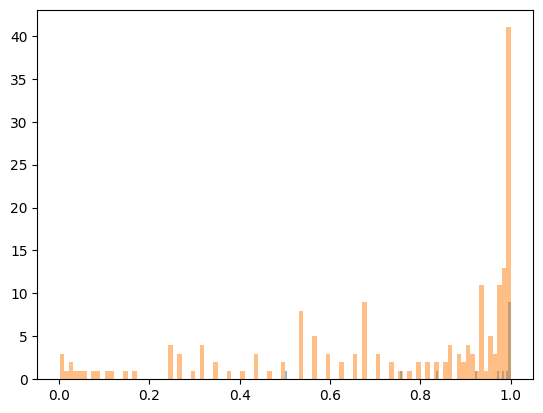

In [14]:
# use the train set to figure out a proper threshold to use!
toxic_yes_probs = comments_dataset.filter(lambda example:example["is_toxic"])["train"]["yes_prob"]
non_toxic_yes_probs = comments_dataset.filter(lambda example:not example["is_toxic"])["train"]["yes_prob"]

plt.hist(toxic_yes_probs, bins=100, alpha=0.5)
plt.hist(non_toxic_yes_probs, bins=100, alpha=0.5)
plt.show()

In [16]:
# Investigate a bit the top comments the model thought is toxic but is not
sorted(zip(toxic_yes_probs, comments_dataset.filter(lambda example:example["is_toxic"])["train"]["text"]), reverse=True)[:5]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

[(0.9997387528419495,
  'Apparently Robert is delusional and would like to pander and hold the hand of a communist dictator who threatens the western world with nuclear holocaust almost daily. North Koreans leaders is a complete nut job. There is no negotiating with a person like that and America damn sure does not need to politely ask how we could help the little fat man.\n\nTrump showed true leadership on this issue. Kim knew (because of Trump) if he attacked us or anyone else it would be the last thing he ever did. Literally the last thing. He has wisely backed down. They do this bs with every new administration to see what they can get away with for the time being. He is a child and Trump spanked him.'),
 (0.9996646642684937,
  'LOCK HER UP. She preys on the most needy people in our society. What a horrible human being.'),
 (0.9996646642684937,
  'Islam still holds grudges going back 1000 years.  The Crusades were  actually an attempt to get back for Europe the Christian lands of T

In [17]:
# The comments are a bit aggressive indeed, but nevertheless not toxic according to the dataset.
# The concept of 'Toxicity' can be a bit subtle, and we've not really taught our model to understand it...

# Evaluate

In [18]:
# Can be tuned to optimise F1 score on train set, or just eyeballed..
YES_PROB_THRESHOLD = 0.99

In [19]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

In [20]:
clf_metrics.compute(
    references=comments_dataset["validation"]["is_toxic"],
    predictions=[True if prob>0.99 else False for prob in comments_dataset["validation"]["yes_prob"]]
)

{'accuracy': 0.73,
 'f1': 0.28947368421052627,
 'precision': 0.2037037037037037,
 'recall': 0.5}

# Final test

In [21]:
# When you're happy with your tuning, run the evaluation on the test set and report your results on the sheet!
clf_metrics.compute(
    references=comments_dataset["test"]["is_toxic"],
    predictions=comments_dataset["test"]["prediction"]
)

{'accuracy': 0.325,
 'f1': 0.15094339622641506,
 'precision': 0.08163265306122448,
 'recall': 1.0}